<a href="https://colab.research.google.com/github/estherkxy/GA_Projects/blob/main/Capstone/code/3_Word2vecModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

import numpy as np
import pandas as pd
import time
import datetime
import random
import io
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading datasets
tw = pd.read_csv('./drive/My Drive/GA/capstone/data/tweets_train.csv', encoding = 'latin-1')
train_df = pd.read_csv('./drive/My Drive/GA/capstone/data/train_tweets_clean.csv')
test_df = pd.read_csv('./drive/My Drive/GA/capstone/data/tweets_test.csv')

# Creating embedding words

In [4]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

tweet_lines = list()
lines = train_df['text'].values.tolist()

for line in lines:
  tokens = word_tokenize(line)
  # convert to lowercase
  #token = [w.lower() for w in tokens]
  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  extra_words = ['get', 'a', 'it', 'why', 'wont', 'u', 'ee']
  extra_words.extend(stop_words)
  words = [w for w in words if not w in extra_words]
  tweet_lines.append(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
len(tweet_lines)

3142

In [6]:
import gensim

embedding_dim = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=tweet_lines, # list of sentences(tweets)
                               size = embedding_dim,  # no. dimensions (size of word vector)
                               window=5,  # only terms that occur within this window are associated with each other during training
                               workers=4, # no. threads used in training parallelization (to speed up training)
                               min_count=1) # only words with freq higher than this are included
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 6335


In [7]:
model.wv.most_similar('horrible')

[('stamfordicenter', 0.5453413128852844),
 ('surges', 0.5245645642280579),
 ('policebodycameras', 0.5138876438140869),
 ('stepinputkeyboard', 0.5136375427246094),
 ('soooo', 0.5110405683517456),
 ('sponsordeal', 0.5050837993621826),
 ('bulls', 0.5038783550262451),
 ('sashametro', 0.5024981498718262),
 ('banking', 0.49910786747932434),
 ('breaks', 0.4987223148345947)]

In [8]:
# save model
filename = 'tweets_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary = False)

# Use Pre-trained Embedding

In [9]:
import os

embeddings_index = {}
f = open(os.path.join('', 'tweets_embedding_word2vec.txt'), encoding = 'utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index[word] = coefs
f.close

<function TextIOWrapper.close>

In [10]:
# convert word embedding into tokenized vector

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweet_lines)
sequences = tokenizer_obj.texts_to_sequences(tweet_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

max_length = max([len(s.split()) for s in train_df['text'].values])
tweet_pad = pad_sequences(sequences, maxlen=max_length)
sentiment = train_df['sentiment'].values

print('Shape of review tensor:', tweet_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

Found 6335 unique tokens.
Shape of review tensor: (3142, 29)
Shape of sentiment tensor: (3142,)


In [11]:
# map embeddings from the loaded word2vec model for each word to the vocab
# create a matrix of word vectors

num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeroes
    embedding_matrix[i] = embedding_vector

In [12]:
num_words

6336

# Instantiating model

In [13]:
!pip install tensorflow_addons

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
import tensorflow_addons as tfa

# define model
model = Sequential()
embedding_layer = Embedding(num_words,
                            embedding_dim, 
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',tfa.metrics.F1Score(num_classes=1),
                       tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 100)           633600    
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 646,497
Trainable params: 12,897
Non-trainable params: 633,600
_________________________________________________________________


# Train-Validation Split

In [16]:
# split dataset into training and validation sets
validation_split = 0.2

indices = np.arange(tweet_pad.shape[0])
np.random.shuffle(indices)
tweet_pad = tweet_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(validation_split * tweet_pad.shape[0])

X_train_pad = tweet_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_val_pad = tweet_pad[-num_validation_samples:]
y_val = sentiment[-num_validation_samples:]

print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)
print('Shape of X_val_pad tensor:', X_val_pad.shape)
print('Shape of y_val tensor:', y_val.shape)

Shape of X_train_pad tensor: (2514, 29)
Shape of y_train tensor: (2514,)
Shape of X_val_pad tensor: (628, 29)
Shape of y_val tensor: (628,)


# Training the model

In [17]:
print('Training model...')

# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(X_train_pad, y_train, batch_size=32, epochs=10, 
          validation_data=(X_val_pad, y_val), callbacks=[callback], verbose=2)

Training model...
Epoch 1/10
79/79 - 10s - loss: 0.6442 - acc: 0.6404 - f1_score: 0.5194 - precision: 0.3281 - recall: 0.0238 - val_loss: 0.6328 - val_acc: 0.6576 - val_f1_score: 0.5083 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 10s/epoch - 124ms/step
Epoch 2/10
79/79 - 5s - loss: 0.6334 - acc: 0.6512 - f1_score: 0.5194 - precision: 0.6190 - recall: 0.0147 - val_loss: 0.6286 - val_acc: 0.6561 - val_f1_score: 0.5083 - val_precision: 0.3750 - val_recall: 0.0140 - 5s/epoch - 59ms/step
Epoch 3/10
79/79 - 4s - loss: 0.6327 - acc: 0.6492 - f1_score: 0.5194 - precision: 0.5000 - recall: 0.0567 - val_loss: 0.6309 - val_acc: 0.6561 - val_f1_score: 0.5083 - val_precision: 0.2500 - val_recall: 0.0047 - 4s/epoch - 55ms/step


In [18]:
# Creating DataFrames for each metric
loss = pd.DataFrame(history.history['loss'], columns = ['train_loss'])
acc = pd.DataFrame(history.history['acc'], columns = ['train_acc'])
val_loss = pd.DataFrame(history.history['val_loss'], columns = ['val_loss'])
val_acc = pd.DataFrame(history.history['val_acc'], columns = ['val_acc'])
f1 = pd.DataFrame(history.history['f1_score'], columns = ['f1_score'])
precision = pd.DataFrame(history.history['precision'], columns = ['precision'])
recall = pd.DataFrame(history.history['recall'], columns = ['recall'])


# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = loss.join(acc).join(val_loss).join(val_acc).join(f1).join(precision).join(recall)

# Use the 'epoch' as the row index.
df_stats['epoch'] = np.arange(len(df_stats))+1
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,train_loss,train_acc,val_loss,val_acc,f1_score,precision,recall
epoch,,,,,,,
1,0.64,0.64,0.63,0.66,0.52,0.33,0.02
2,0.63,0.65,0.63,0.66,0.52,0.62,0.01
3,0.63,0.65,0.63,0.66,0.52,0.50,0.06


As seen from the results table above, the scores are all quite poor across the board. 

In [20]:
# Exporting results
df_stats.to_csv('./drive/My Drive/GA/capstone/data/w2v_results_df.csv')

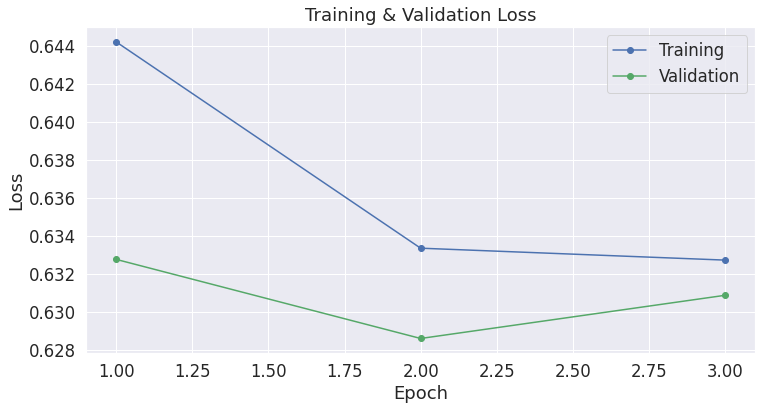

In [38]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['train_loss'], 'b-o', label="Training")
plt.plot(df_stats['val_loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4])

plt.show()

In [22]:
train_pred = model.predict(x=X_train_pad)
val_pred = model.predict(x=X_val_pad)

In [23]:
train_pred_df = pd.DataFrame(train_pred, columns=['predictions'])
train_pred_df['predictions'] = train_pred_df['predictions'].map(lambda x: 1 if x > 0.5 else 0)
train_pred_df['predictions'].value_counts()

0    2487
1      27
Name: predictions, dtype: int64

In [24]:
val_df = pd.DataFrame(val_pred, columns=['predictions'])
val_df['predictions'] = val_df['predictions'].map(lambda x: 1 if x > 0.5 else 0)
val_df['predictions'].value_counts()

0    624
1      4
Name: predictions, dtype: int64

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix

def conf_unravel(true,pred):
  tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
  print("True Negatives: %s" % tn)
  print("False Positives: %s" % fp)
  print("False Negatives: %s" % fn)
  print("True Positives: %s" % tp)

  accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
  print(f'Accuracy: {round(accuracy_clean,4)}')

  misclass_clean = (fp + fn) / (tp + tn + fp + fn)
  print(f'Misclassification Rate: {round(misclass_clean,4)}')

  spec_clean = tn / (tn + fp) #how many of the negatives was correctly classified
  print(f'Specificity: {round(spec_clean,4)}')

  sens_clean = tp / (tp + fn) #how many of the negatives was correctly identified
  print(f'Sensitivity: {round(sens_clean,4)}')

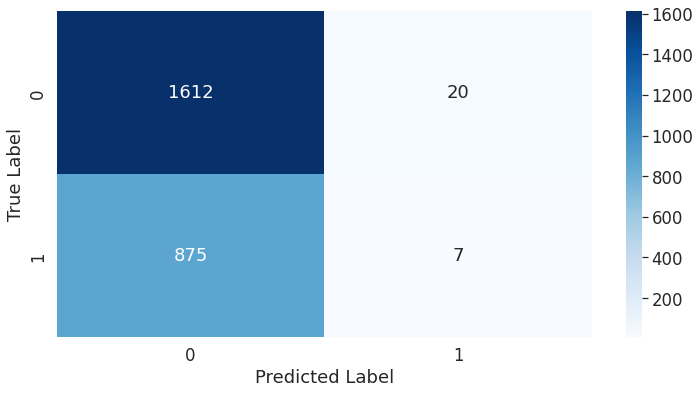

In [26]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_train,train_pred_df['predictions']),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')

In [27]:
conf_unravel(y_train,train_pred_df['predictions'])

True Negatives: 1612
False Positives: 20
False Negatives: 875
True Positives: 7
Accuracy: 0.644
Misclassification Rate: 0.356
Specificity: 0.9877
Sensitivity: 0.0079


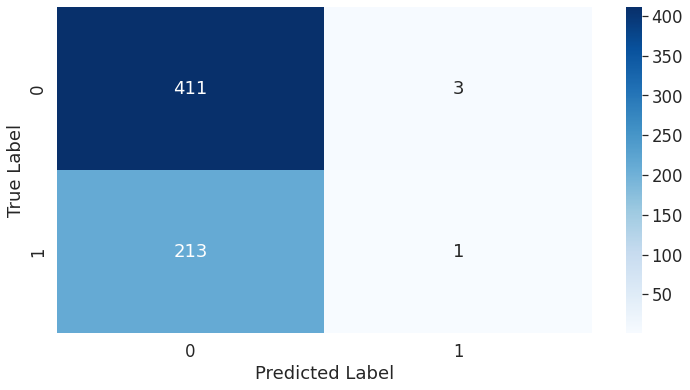

In [28]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_val,val_df['predictions']),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')

In [29]:
conf_unravel(y_val,val_df['predictions'])

True Negatives: 411
False Positives: 3
False Negatives: 213
True Positives: 1
Accuracy: 0.6561
Misclassification Rate: 0.3439
Specificity: 0.9928
Sensitivity: 0.0047


# Performance on Test set

In [30]:
test_df.head()

,id,text,sentiment
0,1,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,2,What Happened To Apple Inc? http://t.co/FJEX...,0
2,3,Thank u @apple I can now compile all of the pi...,1
3,4,The oddly uplifting story of the Apple co-foun...,0
4,5,@apple can i exchange my iphone for a differen...,0


In [31]:
# Reclassifying the target sentiments to binary (0: non-negative, 1: negative)
test_df['sentiment'].replace(1,0, inplace = True)
test_df['sentiment'].replace(-1,1, inplace = True)

# To lowercase 
test_df = test_df.applymap(lambda s:s.lower() if type(s) == str else s)
test_df
test_df.head()

,id,text,sentiment
0,1,wow. yall needa step it up @apple rt @heynyla:...,1
1,2,what happened to apple inc? http://t.co/fjex...,0
2,3,thank u @apple i can now compile all of the pi...,0
3,4,the oddly uplifting story of the apple co-foun...,0
4,5,@apple can i exchange my iphone for a differen...,0


In [32]:
# Tokenize test set
test_tokens = tokenizer_obj.texts_to_sequences(test_df['text'].values)
test_tokens_pad = pad_sequences(test_tokens, maxlen=max_length)

In [33]:
# predict 
predictions = model.predict(x=test_tokens_pad)

In [34]:
pred_df = pd.DataFrame(predictions, columns=['predictions'])
pred_df['sentiment'] = pred_df['predictions'].map(lambda x: 1 if x > 0.5 else 0)
pred_df['sentiment'].value_counts()

0    1619
1      11
Name: sentiment, dtype: int64

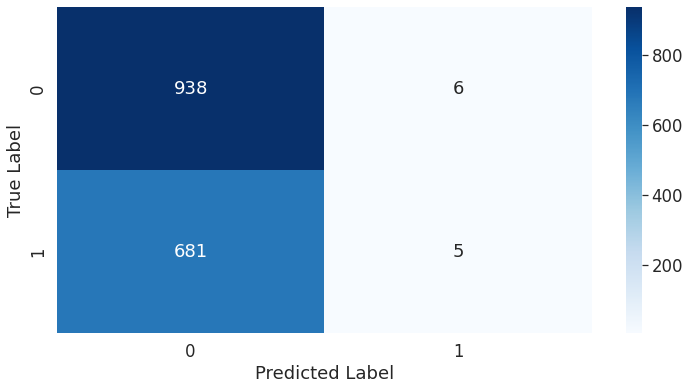

In [35]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_df['sentiment'],pred_df['sentiment']),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')

In [36]:
conf_unravel(test_df['sentiment'],pred_df['sentiment'])

True Negatives: 938
False Positives: 6
False Negatives: 681
True Positives: 5
Accuracy: 0.5785
Misclassification Rate: 0.4215
Specificity: 0.9936
Sensitivity: 0.0073


As seen from the confusion matrix, the scores are all pretty bad with the exception of the specificity(True negative) score. This means that the model is good at correctly classifying non-negative tweets. However, as one of the main objective is to correctly classify negative tweets. This model is deemed to be not as helpful. 